# Example notebook for using RS propagation from propagate module 

In the following we exemplify Rayleigh-Sommerfeld (RS) propagation from elements via the ``generate`` module illuminated with plane waves, using the ``propagate`` module. In particular:
* Several examples of RS propagations in Z axis, YZ and XY planes:
    * RS propagation from elements defined from library functions apertures (e.g. Fresnel lenses)
    * RS propagation from elements defined from arbitrarily defined functions (e.g. Spiral Phase Plate)

In the ``propagate`` module, Rayleigh-Sommerfeld propagation is implemented via direct numerical integration of a double integral (see, e.g. Goodman Fourier Optics textbook as reference), making it (very) time-consuming, yet exact. 

Fresnel and Fraunhofer propagations provide acceptable approximations with faster computation for the propagation in some ranges. In the ``propagate`` module these approximations have been implemented following the Goodman Fourier Optics textbook. For simple use examples of Fresnel and Fraunhofer propagations check propopt package https://github.com/cunhaJ/propopt .
    

In [43]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../..')

from matplotlib import pyplot as plt 
import numpy as np 

from scipy.constants import micro, nano, milli

import pyMOE as moe 

# Propagation from a circular aperture

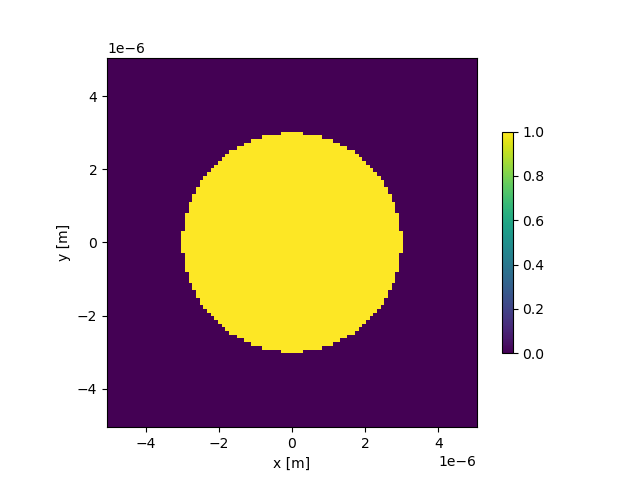

In [44]:
# Generates the mask aperture

aperture_width = 10*micro
aperture_height = 10*micro
x_pixel = 100
y_pixel = 100

aperture = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel,)

radius =  3*micro

mask = moe.generate.circular_aperture(aperture, radius=radius)
moe.plotting.plot_aperture(mask)


1.0101010101010137e-07

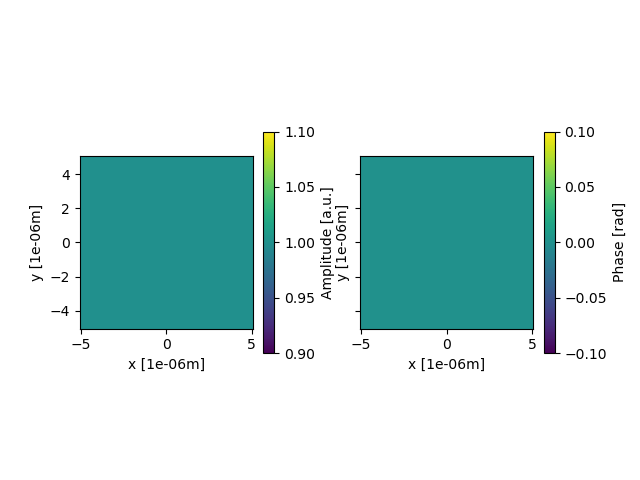

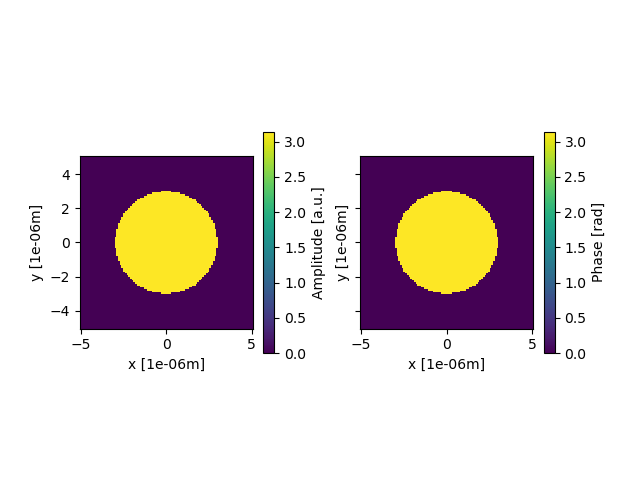

In [45]:
# Calculates a field to use with the calculated mask


# First creates a field object with the same spatial coordinates from the provided mask
field = moe.field.create_empty_field_from_aperture(mask)

# Then calculates a gaussian field with the given parameters
field = moe.field.generate_gaussian_field(field, E0=1, w0=50*micro)

# or a uniform field
field = moe.field.generate_uniform_field(field, E0=1)
moe.plotting.plot_field(field, scale=micro)

mask_phase = mask 
mask_phase.aperture = mask.aperture*np.pi

# Modulates the field with a given aperture that can be used either as an amplitude mask or a phase mask
field = moe.field.modulate_field(field, amplitude_mask=mask, phase_mask=mask_phase)


moe.plotting.plot_field(field, scale=micro)

field.pixel_x


In [38]:
# Propagates a field onto a provided screen detector in XY

# define the wavelength used in the propagation
wavelength = 532*nano

# Define the screen size and create it
screen_width = 50*micro
screen_height = 50*micro
x_pixel = 101
y_pixel = 101


# Creates an empty target XY screen object with a width and height and placed at a distance z
screen_XY = moe.field.create_screen_XY(-screen_width/2, screen_width/2, x_pixel,
                                     -screen_height/2, screen_height/2, y_pixel, 
                                     z=100*micro)

# Propagates a given field onto the target screen
screen_XY = moe.propagate.RS_integral(field, screen_XY, wavelength, parallel_computing=True)

moe.plotting.plot_screen_XY(screen_XY)

[########################################] | 100% Completed | 32.01 s


<IPython.core.display.Javascript object>

In [39]:
# Propagates a field onto a provided screen detector in YZ

# Creates a screen with Y range between ±500µm and z between 10µm and 1.5mm, placed at x=0
screen_YZ = moe.field.create_screen_YZ(-5*micro,5*micro, 101, 
                                        0*micro, 50*micro, 101,
                                        x=0)

# Propagates the field
screen_YZ = moe.propagate.RS_integral(field, screen_YZ, wavelength, parallel_computing=True)

moe.plotting.plot_screen_YZ(screen_YZ)

[########################################] | 100% Completed | 29.26 s


<IPython.core.display.Javascript object>

In [40]:
# Plot just the field amplitude of the screen
moe.plotting.plot_screen_YZ(screen_YZ, which='amplitude')

<IPython.core.display.Javascript object>

In [41]:
# Propagates the field in a single line along the Z axis
screen_ZZ = moe.field.create_screen_ZZ(0*micro, 50*micro, 1001)
screen_ZZ = moe.propagate.RS_integral(field, screen_ZZ, wavelength, parallel_computing=True)

moe.plotting.plot_screen_ZZ(screen_ZZ, scale=micro, which='amplitude')

[########################################] | 100% Completed | 3.36 sms


<IPython.core.display.Javascript object>

## Verifying the propagation against numerical result and previous implementation

In [42]:
###Previous implementation 
####Propagate field and calculate in plane YZ, using npix bins in Y
zmin = 0
zmax = 50e-6
nzs = 101
xsiz = 10e-6
xplus = xsiz/2
xminus = -xplus
Em = mask.aperture * np.exp(1.0j*mask_phase.aperture)
npix = 100
pixsize = xsiz/npix
lda = wavelength
 

RS_results = moe.propagate.RS_intYZ(zmin,zmax,nzs,0,mask_phase.aperture, npix, pixsize, npix, xplus, xplus, lda,1,verbose=True)
field = RS_results[0] ##E field 

##Plot the YZ propagation 
fig = plt.figure(figsize=(7,4)) 

zp = np.linspace(zmin,zmax,nzs)
yp = np.linspace(xminus,xplus,npix)
z = field

plt.pcolormesh(zp,yp,np.abs(z)**2)
plt.colorbar()
plt.xlabel("z [m]")
plt.ylabel("y [m]")

plt.tight_layout()

Progress: [####################] 100.0%
Elapsed: 0:00:15.684389


<IPython.core.display.Javascript object>

In [46]:
##Propagate field using RS integal 
RS_results2 = moe.propagate.RS_intZZ(zmin,zmax,1001,0,0, Em, npix, pixsize, npix, xplus, xplus, lda,1, verbose=True)
field2 = RS_results2[2] ##Intensity log 


Progress: [####################] 100.0%
Elapsed: 0:00:02.183867


Text(0, 0.5, 'E norm (a.u.)')

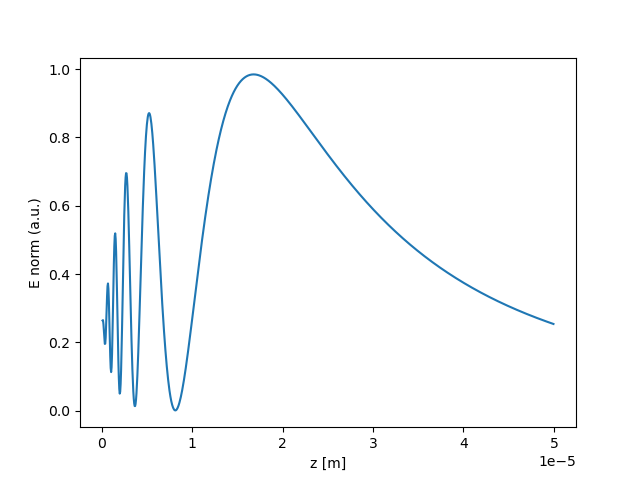

In [47]:
fig = plt.figure() 

zp = np.linspace(zmin,zmax,1001)
ef = RS_results2[1]

plt.plot(zp[2:-1],ef[2:-1])
plt.xlabel("z [m]")
plt.ylabel("E norm (a.u.)")

#plt.savefig("FZP-Zprop.png")


### Analytical comparison to new implementation and previous results

In [48]:
###Analytical functions for a circular aperture 

def circ_zz28(aperture_rad, zdist, wavelength):
    """
    implements circular aperture fresnel approximation analytic solution for x-z planes, Sheppard  1992, exp28 
    ###This function is the axial intensity for a circular aperture following 1992 Sheppard paper, exp (28) 
    inputs: 
    aperture_rad = aperture radius in m
    zdist = distance to screen in m 
    wavelength = wavelength in m 
    
    returns intensity 
    
    """
    import numpy as np 
    
    k = 2*np.pi /wavelength 
    
    izz1 = (1 + np.sqrt(1 + aperture_rad**2 /zdist**2))
    izz2 = 1 + aperture_rad**2/(2*zdist**2)
    izz3 = (k * aperture_rad**2/(2 *zdist))/(np.sqrt(1+aperture_rad**2/zdist**2)+1)
    itot = 0.25*(izz1/izz2) * np.sin(izz3)**2
    
    return itot


def circ_zz24(aperture_rad, zdist, wavelength):
    """
    implements circular aperture fresnel approximation analytic solution for x-z planes, Sheppard  1992 , exp24
    ###This function is the axial intensity for a circular aperture following 1992 Sheppard paper, exp (24) 
    inputs: 
    aperture_rad = aperture radius in m
    zdist = distance to screen in m 
    wavelength = wavelength in m 
    
    returns intensity 
    
    """
    import numpy as np 
    
    k = 2*np.pi /wavelength 
    
    izz1 = 1/(1+aperture_rad**2/zdist**2)
    izz2 = 2/np.sqrt(1+aperture_rad**2/zdist**2)
    izz3 = (k * aperture_rad**2/(zdist)) /(np.sqrt(1+aperture_rad**2/zdist**2)+1)
    itot = 0.25*(1+izz1-izz2* np.cos(izz3))
    
    return itot
    
    

def circ_zzdubra(aperture_rad, zdist, wavelength):
    """
    implements circular aperture fresnel approximation analytic solution from dubra 1999 paper, eq 14 
 
    inputs: 
    aperture_rad = aperture radius in m
    zdist = distance to screen in m 
    wavelength = wavelength in m 
    
    returns intensity 
    
    """
    import numpy as np 
    
    k = 2*np.pi /wavelength 
    
    izzcos = np.cos(k*zdist*(np.sqrt(1+(aperture_rad/zdist)**2)-1))

    itot = 1 + zdist**2/(zdist**2+aperture_rad**2)-2*zdist/np.sqrt(zdist**2+aperture_rad**2)*izzcos
    
    return itot

C:\Users\diogo\AppData\Local\Temp\ipykernel_3636\1032532052.py:19: RuntimeWarning: divide by zero encountered in true_divide
  izz1 = (1 + np.sqrt(1 + aperture_rad**2 /zdist**2))
C:\Users\diogo\AppData\Local\Temp\ipykernel_3636\1032532052.py:20: RuntimeWarning: divide by zero encountered in true_divide
  izz2 = 1 + aperture_rad**2/(2*zdist**2)
C:\Users\diogo\AppData\Local\Temp\ipykernel_3636\1032532052.py:21: RuntimeWarning: divide by zero encountered in true_divide
  izz3 = (k * aperture_rad**2/(2 *zdist))/(np.sqrt(1+aperture_rad**2/zdist**2)+1)
C:\Users\diogo\AppData\Local\Temp\ipykernel_3636\1032532052.py:21: RuntimeWarning: invalid value encountered in true_divide
  izz3 = (k * aperture_rad**2/(2 *zdist))/(np.sqrt(1+aperture_rad**2/zdist**2)+1)
C:\Users\diogo\AppData\Local\Temp\ipykernel_3636\1032532052.py:22: RuntimeWarning: invalid value encountered in true_divide
  itot = 0.25*(izz1/izz2) * np.sin(izz3)**2
C:\Users\diogo\AppData\Local\Temp\ipykernel_3636\1032532052.py:43: Runtim

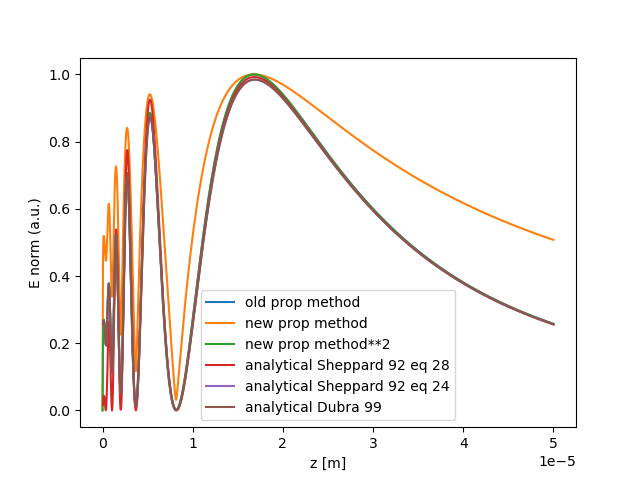

In [49]:
zarray = np.linspace(0,zmax,1001)
aperture_rad = 3*micro


ivals_zz28 = circ_zz28(aperture_rad, zarray, wavelength)
ivals_zz24 = circ_zz24(aperture_rad, zarray, wavelength)
ivals_zzdubra = circ_zz24(aperture_rad, zarray, wavelength)
#fig = plt.figure() 
#plt.plot(zarray, ivals)

#screen_ZZ.amplitude = screen_ZZ.amplitude/np.max(screen_ZZ.amplitude)

#moe.plotting.plot_screen_ZZ(screen_ZZ, scale=micro,  which='amplitude')
fig = plt.figure()
plt.plot(zp[2:-1],ef[2:-1]/np.max(ef[2:-1]), label='old prop method')
plt.plot(zarray, screen_ZZ.amplitude[0][0]/np.max(screen_ZZ.amplitude), label='new prop method')
plt.plot(zarray, (screen_ZZ.amplitude[0][0]/np.max(screen_ZZ.amplitude))**2, label='new prop method**2')
plt.plot(zarray, ivals_zz28*2 , label='analytical Sheppard 92 eq 28')
plt.plot(zarray, ivals_zz24, label='analytical Sheppard 92 eq 24')
plt.plot(zarray, ivals_zzdubra, label='analytical Dubra 99')
plt.plot


plt.legend(fontsize='10')

plt.xlabel("z [m]")
plt.ylabel("E norm (a.u.)")

plt.savefig("comparison.png")


## Propagation of a Fresnel multilevel mask example #1

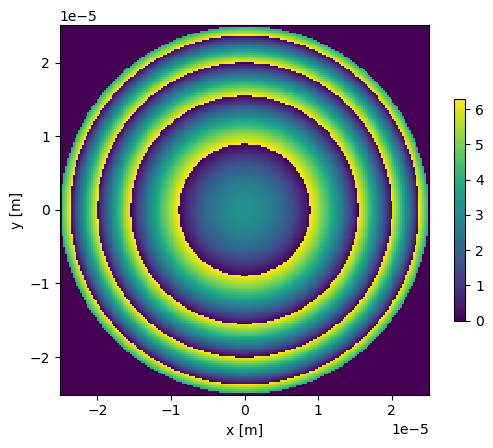

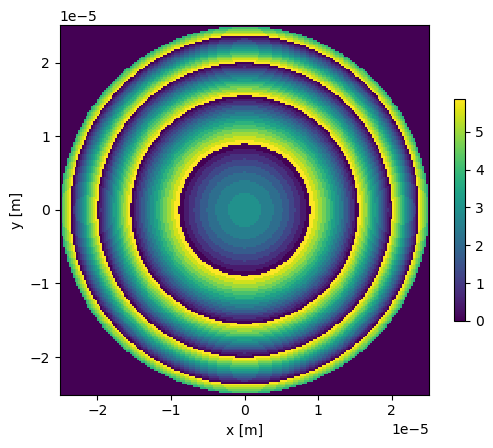

In [58]:
# Generates the mask aperture

aperture_width = 50*micro
aperture_height = 50*micro
x_pixel = 200
y_pixel = 200

aperture = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel,)

wavelength = 532*nano
focal_length = 150*micro
radius = 25*micro

mask = moe.generate.fresnel_phase(aperture, focal_length=focal_length, wavelength=wavelength, radius=radius)
moe.plotting.plot_aperture(mask)

# Set 16 phase levels to discretize the fresnel mask
phase_values = np.linspace(0, 2*np.pi, 16)
mask.discretize(phase_values)

moe.plotting.plot_aperture(mask)


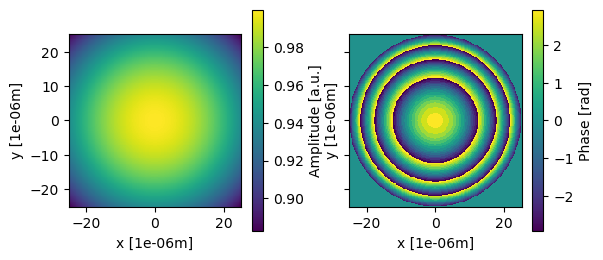

In [59]:
# Create a field 


# Calculates a field to use with the calculated mask


# First creates a field object with the same spatial coordinates from the provided mask
field = moe.field.create_empty_field_from_aperture(mask)

# Then calculates a gaussian field with the given parameters
field = moe.field.generate_gaussian_field(field, E0=1, w0=100*micro)


field = moe.field.modulate_field(field, amplitude_mask=None, phase_mask=mask)


moe.plotting.plot_field(field, scale=micro)



[########################################] | 100% Completed | 16.53 s


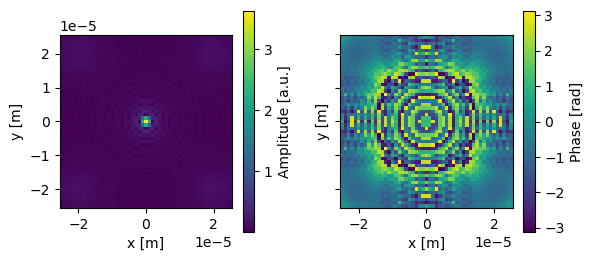

In [60]:
# Propagates a field onto a provided screen detector in XY

# Define the screen size and create it
screen_width = 50*micro
screen_height = 50*micro
x_pixel = 51
y_pixel = 51

# set the screen plane to match the design focal length
z_distance = focal_length

# Creates an empty target XY screen object with a width and height and placed at a distance z
screen_XY = moe.field.create_screen_XY(-screen_width/2, screen_width/2, x_pixel,
                                     -screen_height/2, screen_height/2, y_pixel, 
                                     z=z_distance)

# Propagates a given field onto the target screen
screen_XY = moe.propagate.RS_integral(field, screen_XY, wavelength, parallel_computing=True)

moe.plotting.plot_screen_XY(screen_XY)

[########################################] | 100% Completed | 73.05 s


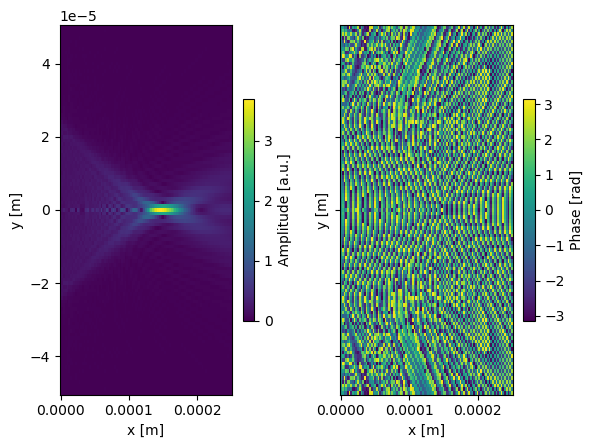

In [64]:
# Propagates a field onto a provided screen detector in YZ

# Creates a screen with Y range between ±500µm and z between 10µm and 1.5mm, placed at x=0
screen_YZ = moe.field.create_screen_YZ(-50*micro,50*micro, 101, 
                                        0*micro, 250*micro, 101,
                                        x=0)

# Propagates the field
screen_YZ = moe.propagate.RS_integral(field, screen_YZ, wavelength, parallel_computing=True)

moe.plotting.plot_screen_YZ(screen_YZ)

[########################################] | 100% Completed | 2.44 sms


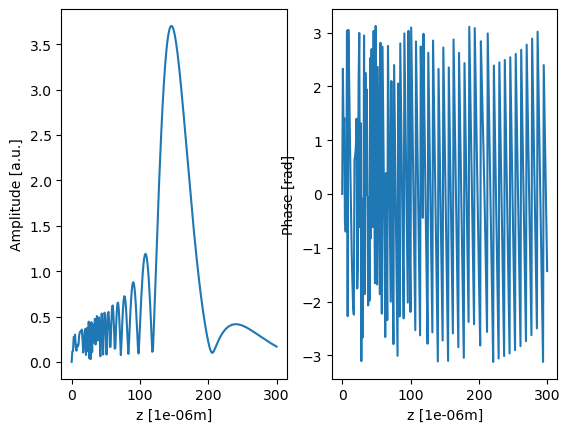

In [70]:
# Propagates the field in a single line along the Z axis
screen_ZZ = moe.field.create_screen_ZZ(0*micro, 300*micro, 301)
screen_ZZ = moe.propagate.RS_integral(field, screen_ZZ, wavelength, parallel_computing=True)

moe.plotting.plot_screen_ZZ(screen_ZZ, scale=micro)

## Details of the screen object and propagation functions

In [76]:
# the screen object contains a 3 dimensional array with the respective planes XY, YZ or ZZ.
# the propagation function is agnostic on the screen plane but will evaluate the field contribution for 
# each provided screen position in the 3 dimensional array

screen_XY.shape, screen_YZ.shape, screen_ZZ.shape

((51, 51, 1), (1, 101, 101), (1, 1, 301))

In [79]:
# the screen object has the complex field stored inside the .screen variable
# the .XX, .YY and .ZZ variables have the respective meshgrid positions

print(screen_XY.screen), print(screen_XY.XX)

[[[0.04469079+0.00295675j]
  [0.04644149+0.0083569j ]
  [0.07199051-0.02014114j]
  ...
  [0.07199051-0.02014114j]
  [0.04644149+0.0083569j ]
  [0.04469079+0.00295675j]]

 [[0.04644149+0.0083569j ]
  [0.07202538-0.01634194j]
  [0.06486582-0.03024394j]
  ...
  [0.06486582-0.03024394j]
  [0.07202538-0.01634194j]
  [0.04644149+0.0083569j ]]

 [[0.07199051-0.02014114j]
  [0.06486582-0.03024394j]
  [0.07626327-0.06481668j]
  ...
  [0.07626327-0.06481668j]
  [0.06486582-0.03024394j]
  [0.07199051-0.02014114j]]

 ...

 [[0.07199051-0.02014114j]
  [0.06486582-0.03024394j]
  [0.07626327-0.06481668j]
  ...
  [0.07626327-0.06481668j]
  [0.06486582-0.03024394j]
  [0.07199051-0.02014114j]]

 [[0.04644149+0.0083569j ]
  [0.07202538-0.01634194j]
  [0.06486582-0.03024394j]
  ...
  [0.06486582-0.03024394j]
  [0.07202538-0.01634194j]
  [0.04644149+0.0083569j ]]

 [[0.04469079+0.00295675j]
  [0.04644149+0.0083569j ]
  [0.07199051-0.02014114j]
  ...
  [0.07199051-0.02014114j]
  [0.04644149+0.0083569j ]
  [

(None, None)

## Propagation from a Fresnel Zone Plate

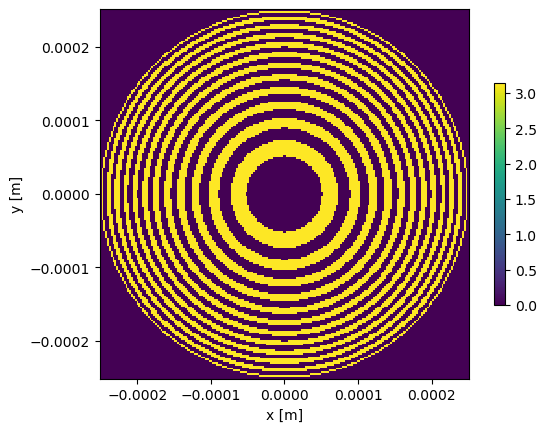

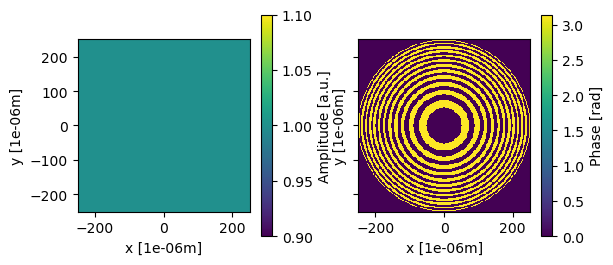

In [117]:
# the Fresnel zone plane can be calculated from the fresnel lens function considering only 2 levels
# and an aperture mask

aperture_width = 500*micro
aperture_height = 500*micro
x_pixel = 200
y_pixel = 200

aperture = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel,)

wavelength = 532*nano
focal_length = 5*milli
radius = aperture_width/2

mask = moe.generate.fresnel_phase(aperture, focal_length=focal_length, wavelength=wavelength, radius=radius)

# Set 16 phase levels to discretize the fresnel mask
phase_values = np.linspace(0, np.pi, 2)
mask.discretize(phase_values)

moe.plotting.plot_aperture(mask)


# Creates the field and modulates as aperture

field = moe.field.create_empty_field_from_aperture(mask)
field = moe.field.generate_uniform_field(field, E0=1)
# field = moe.field.modulate_field(field, amplitude_mask=mask, phase_mask=None)
field = moe.field.modulate_field(field, amplitude_mask=None, phase_mask=mask)


moe.plotting.plot_field(field, scale=micro)



[########################################] | 100% Completed | 15.67 s


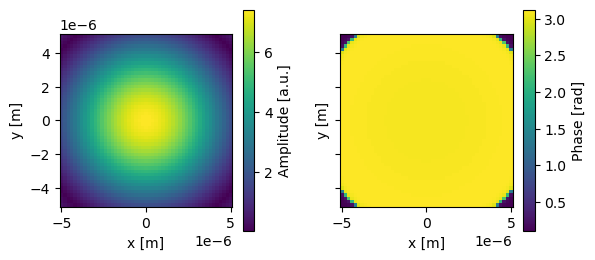

In [118]:
# Propagates a field onto a provided screen detector in XY

# Define the screen size and create it
screen_width = 10*micro
screen_height = 10*micro
x_pixel = 51
y_pixel = 51

# set the screen plane to match the design focal length
z_distance = focal_length

# Creates an empty target XY screen object with a width and height and placed at a distance z
screen_XY = moe.field.create_screen_XY(-screen_width/2, screen_width/2, x_pixel,
                                     -screen_height/2, screen_height/2, y_pixel, 
                                     z=z_distance)

# Propagates a given field onto the target screen
screen_XY = moe.propagate.RS_integral(field, screen_XY, wavelength, parallel_computing=True)

moe.plotting.plot_screen_XY(screen_XY)

[########################################] | 100% Completed | 70.79 s


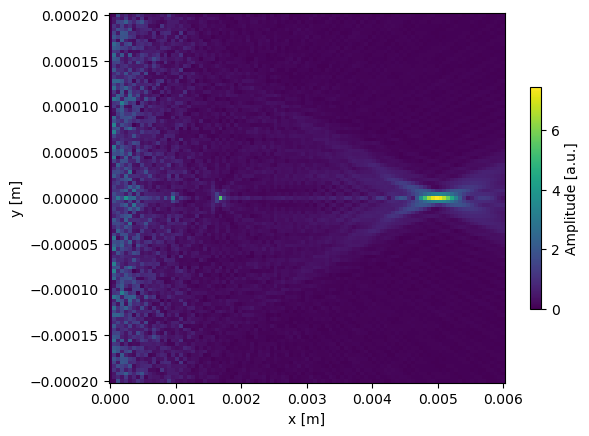

In [123]:
# Propagates a field onto a provided screen detector in YZ

# Creates a screen with Y range between ±500µm and z between 10µm and 1.5mm, placed at x=0
screen_YZ = moe.field.create_screen_YZ(-200*micro,200*micro, 101, 
                                        0*micro, 6000*micro, 101,
                                        x=0)

# Propagates the field
screen_YZ = moe.propagate.RS_integral(field, screen_YZ, wavelength, parallel_computing=True)

moe.plotting.plot_screen_YZ(screen_YZ, which='amplitude')

[########################################] | 100% Completed | 6.45 sms


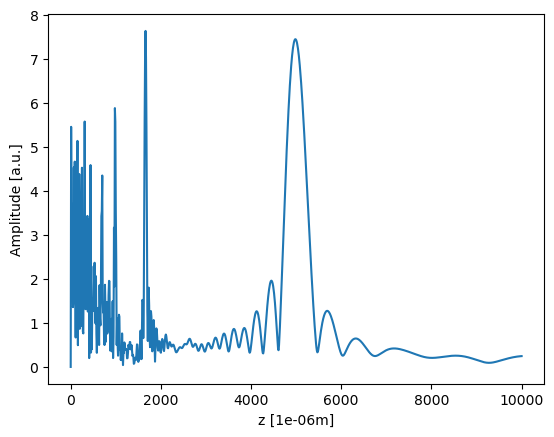

In [124]:
# Propagates the field in a single line along the Z axis
screen_ZZ = moe.field.create_screen_ZZ(0*micro, 10000*micro, 1001)
screen_ZZ = moe.propagate.RS_integral(field, screen_ZZ, wavelength, parallel_computing=True)

moe.plotting.plot_screen_ZZ(screen_ZZ, scale=micro,  which='amplitude')

## Propagation from a Spiral Phase Plate

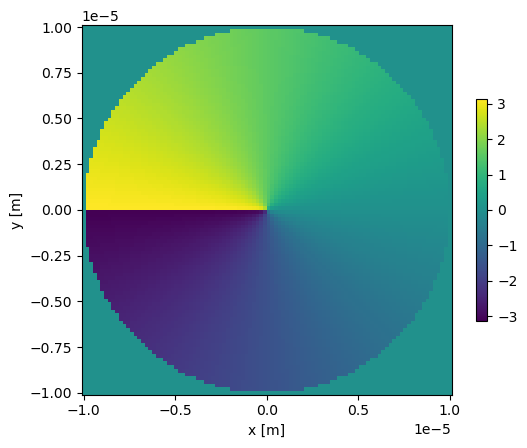

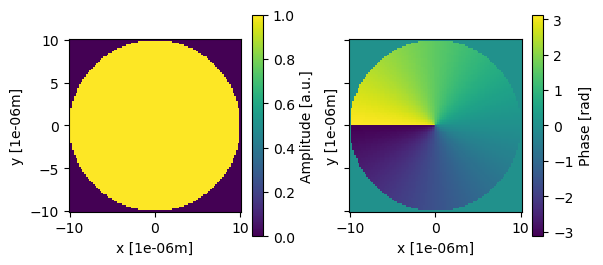

In [142]:
# Generates and propagates a spiral phase plate

aperture_width = 20*micro
aperture_height = 20*micro
x_pixel = 100
y_pixel = 100

aperture = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel,)

wavelength = 532*nano
L = 1
radius = 10*micro

mask =  moe.generate.arbitrary_aperture_function(aperture, moe.sag.spiral, L=L)
mask = moe.generate.truncate_aperture_radius(mask, radius=radius,)

# # Set 16 phase levels to discretize the fresnel mask
# phase_values = np.linspace(0, np.pi, 2)
# mask.discretize(phase_values)

moe.plotting.plot_aperture(mask)

# Generates a circular aperture for the spiral plate

aperture = moe.generate.create_empty_aperture_from_aperture(mask)

mask_circle = moe.generate.circular_aperture(aperture, radius=radius)


field = moe.field.create_empty_field_from_aperture(mask)
field = moe.field.generate_uniform_field(field, E0=1)
# field = moe.field.modulate_field(field, amplitude_mask=mask, phase_mask=None)
field = moe.field.modulate_field(field, amplitude_mask=mask_circle, phase_mask=mask)


moe.plotting.plot_field(field, scale=micro)



[########################################] | 100% Completed | 13.08 s
[########################################] | 100% Completed | 8.89 ss


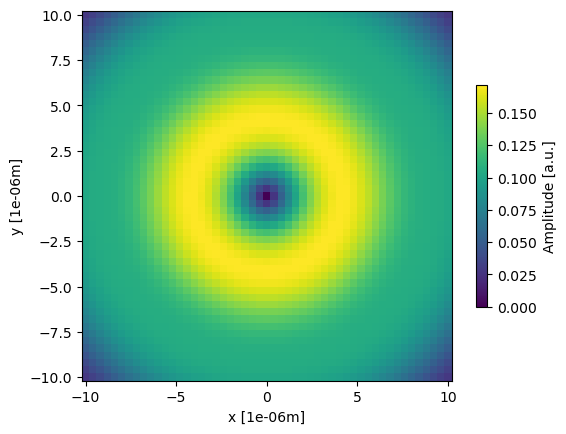

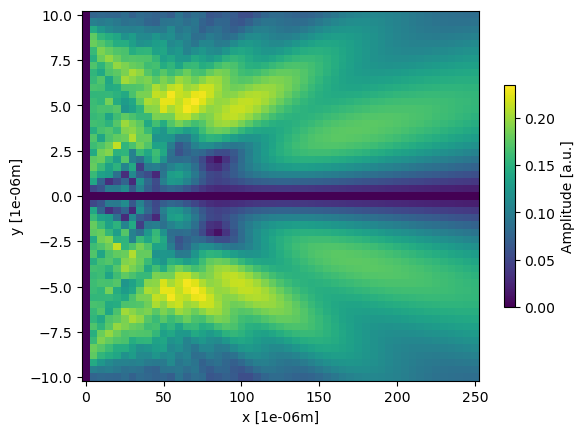

In [150]:
# Propagates a field onto a provided screen detector in XY

# Define the screen size and create it
screen_width = 20*micro
screen_height = 20*micro
x_pixel = 51
y_pixel = 51

# set the screen plane to match the design focal length
z_distance = 200*micro

# Creates an empty target XY screen object with a width and height and placed at a distance z
screen_XY = moe.field.create_screen_XY(-screen_width/2, screen_width/2, x_pixel,
                                     -screen_height/2, screen_height/2, y_pixel, 
                                     z=z_distance)

# Propagates a given field onto the target screen
screen_XY = moe.propagate.RS_integral(field, screen_XY, wavelength, parallel_computing=True)

moe.plotting.plot_screen_XY(screen_XY, which='amplitude', scale=micro)



# Creates a screen with Y range between ±500µm and z between 10µm and 1.5mm, placed at x=0
screen_YZ = moe.field.create_screen_YZ(-10*micro,10*micro, 51, 
                                        0*micro, 250*micro, 51,
                                        x=0)

# Propagates the field
screen_YZ = moe.propagate.RS_integral(field, screen_YZ, wavelength, parallel_computing=True)

moe.plotting.plot_screen_YZ(screen_YZ, which='amplitude', scale=micro)

# Alvarez lens example

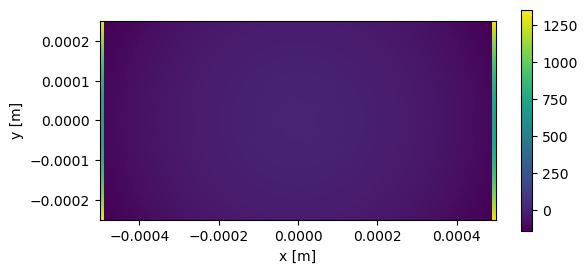

In [161]:
# Creates an Alvarez lens pair masks
# evaluates the produced focal spot by the displaced lenses using the propagation
aperture_width = 1000*micro
aperture_height = 500*micro
x_pixel = 1000
y_pixel = 500


# focal range of the Alvarez lenses
f1 = 500*micro
f2 = 15000*micro
tuning_distance = 100*micro
wavelength = 1550*nano


# First lens
aperture = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel,)
lens1 =  moe.generate.arbitrary_aperture_function(aperture, moe.sag.Alvarez_phase, f1=f1, f2=f2, tuning_distance=tuning_distance, wavelength=wavelength)


# Second lens which is the same but flipped.
aperture2 = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel,)

lens2 =  moe.generate.arbitrary_aperture_function(aperture2, moe.sag.Alvarez_phase, f1=f1, f2=f2, tuning_distance=tuning_distance, wavelength=wavelength)
lens2.aperture = np.fliplr(lens2.aperture)


# initializes an aperture to store the result
result = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel,)



# displace aperture equally both ways, total displacement is twice displacement
displacement = 12*micro
rollidx = int(np.round(displacement/lens1.pixel_x,))

roll = rollidx
lens1.aperture = np.roll(lens1.aperture, -roll, axis=1)
lens2.aperture = np.roll(lens2.aperture, roll, axis=1)

lens1.aperture[:,-roll:] = 0
lens2.aperture[:,:roll] = 0


# Plots the lenses
# moe.plotting.plot_aperture(lens1) 
# moe.plotting.plot_aperture(lens2) 



# Calculates the resulting aperutre by the sum of both displaced lens1 and lens2
result.aperture = -lens1.aperture - lens2.aperture


# result.modulos(2*np.pi)
moe.plotting.plot_aperture(result) 

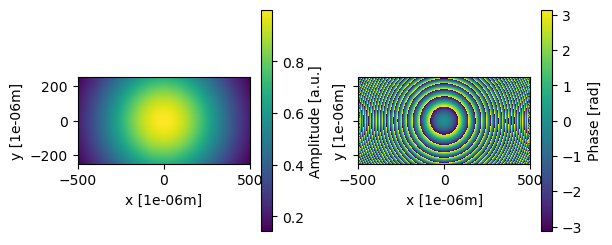

In [162]:
# Creates a mask from the result, and modulates the phase of a gaussian field

mask = result
field = moe.field.create_empty_field_from_aperture(mask)
field = moe.field.generate_gaussian_field(field, E0=1, w0=400*micro)

field = moe.field.modulate_field(field, amplitude_mask=None, phase_mask=mask)

moe.plotting.plot_field(field, scale=micro)


[########################################] | 100% Completed | 14m 25s


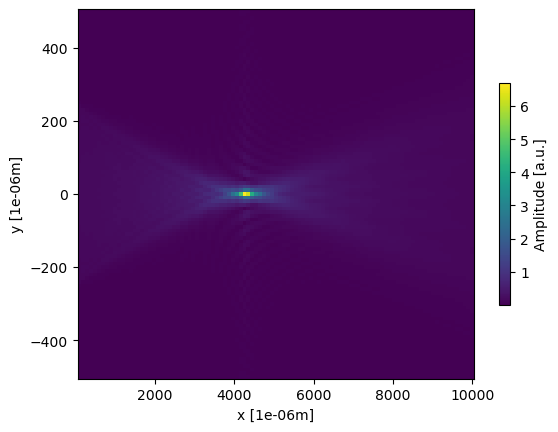

In [174]:
screen_YZ = moe.field.create_screen_YZ(-500*micro,500*micro, 101, 100*micro, 10000*micro, 101)
screen_YZ = moe.propagate.RS_integral(field, screen_YZ, wavelength, )

moe.plotting.plot_screen_YZ(screen_YZ, which='amplitude', scale=micro)

[                                        ] | 0% Completed | 600.40 us[########################################] | 100% Completed | 14.86 s


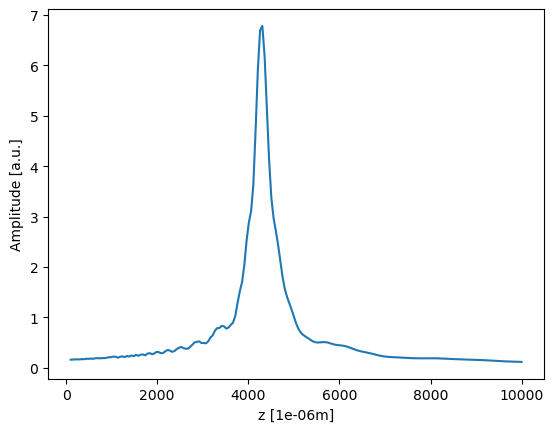

In [165]:
screen_ZZ = moe.field.create_screen_ZZ(100*micro, 10000*micro, 201)
screen_ZZ = moe.propagate.RS_integral(field, screen_ZZ, wavelength)

moe.plotting.plot_screen_ZZ(screen_ZZ, which='amplitude', scale=micro)

[########################################] | 100% Completed | 66.76 s


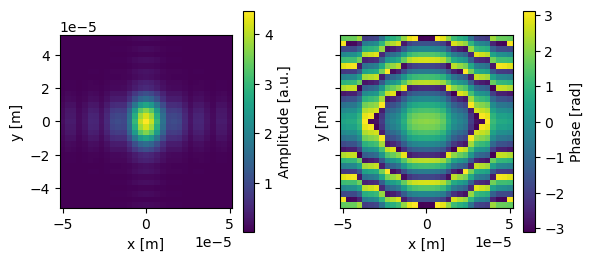

In [171]:


screen_XY = moe.field.create_screen_XY(-50*micro,50*micro, 31, 
                                        -50*micro,50*micro, 31, 
                                        z=4150*micro)

screen_XY = moe.propagate.RS_integral(field, screen_XY, wavelength)

moe.plotting.plot_screen_XY(screen_XY)

## Propagation of holograms

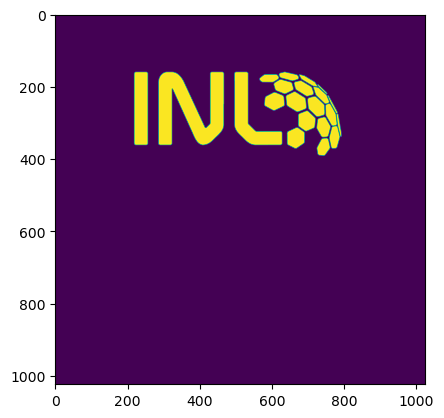

In [201]:
from PIL import Image
file = "..\\6 - Holograms\\target.png"

target = Image.open(file).convert("L")

size = 128
target = target.resize((size,size))
target = np.array(target)/255

plt.imshow(target)

Progress: [####################] 100.0%
[Gerchberg Saxton Algorithm]
Elapsed: 0:00:14.546305


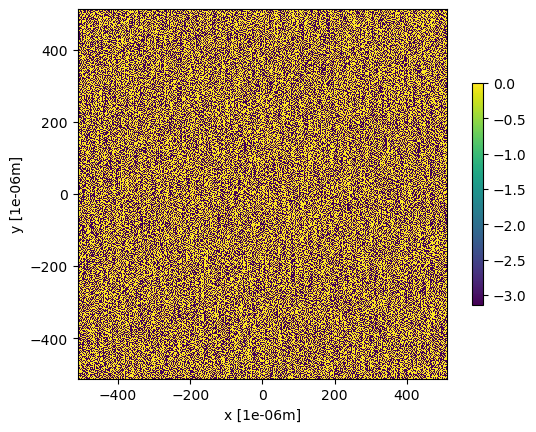

In [202]:
# Binary level phase mask
levels = 2

iterations = 20

levels = moe.utils.create_levels(-np.pi, np.pi, levels,)
phase_mask, errors = moe.holograms.algorithm_Gerchberg_Saxton(target, iterations=iterations, levels=levels)

phase_mask = moe.holograms.correct_mask_shift(phase_mask)
mask = moe.generate.create_aperture_from_array(phase_mask, pixel_size=(1*micro, 1*micro), center=True, )




# Discretize to same levels as original
mask.discretize(levels)
moe.plotting.plot_aperture(mask, scale=micro)

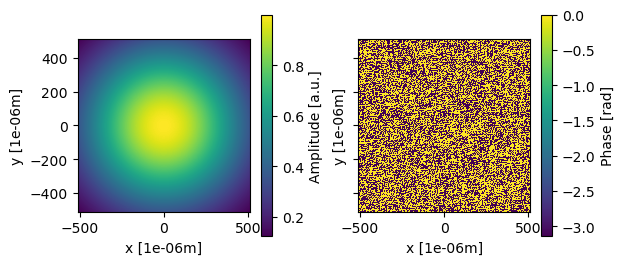

In [204]:
# Create the gaussian field to propagate through the hologram


field = moe.field.create_empty_field_from_aperture(mask)
field = moe.field.generate_gaussian_field(field, E0=1, w0=500*micro)
# field = moe.field.modulate_field(field, amplitude_mask=mask, phase_mask=None)
field = moe.field.modulate_field(field, amplitude_mask=None, phase_mask=mask)


moe.plotting.plot_field(field, scale=micro)



In [205]:

# define the wavelength used in the propagation
wavelength = 532*nano

# Define the screen size and create it
screen_width = 5000*micro
screen_height = 5000*micro
x_pixel = 64
y_pixel = 64

screen_XY = moe.field.create_screen_XY(-screen_width/2, screen_width/2, x_pixel,
                                     -screen_height/2, screen_height/2, y_pixel, 
                                     z=15000*micro)

screen_XY = moe.propagate.RS_integral(field, screen_XY, wavelength)

moe.plotting.plot_screen_XY(screen_XY)

[                                        ] | 1% Completed | 13.07 sms


KeyboardInterrupt: 